In [1]:
import ee
import xarray
ee.Initialize()

s2_imgCol = (ee.ImageCollection('COPERNICUS/S2_HARMONIZED')
                  .filterDate('2022-01-01', '2022-01-31')
                  .filterBounds(ee.Geometry.Point([-121.52362180406335,40.13422437870105]))
                  .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20))

    )

ds = xarray.open_dataset(s2_imgCol, 
                         engine='ee', 
                         projection=s2_imgCol.first().select(0).projection(),
                        #  crs='EPSG:32610',
                        #  geometry= i.first().geometry(),
                         geometry=s2_imgCol.first().geometry(),
                         scale=10,
                    )

ds

In [2]:
import matplotlib.pyplot as plt
from matplotlib import animation
import cartopy.crs as ccrs
from IPython.display import HTML

def animate(i):
    # array = da[i,:,:].values
    # im.set_array(array.flatten())
    plt.imshow(da[i,:,:])
    ax.set_title(f'Sentinel-2, {str(da.time[i].values)[:-16]}', fontsize=12)

da = ds.B1
frames = da.shape[0]

fig = plt.figure(figsize=(10, 5)) # Define the figure and specify size
ax = plt.subplot(1,1,1)
ax.imshow(da[0,:,:])

fig.tight_layout()

ani = animation.FuncAnimation(fig, animate, frames, interval=150)
ani.save(f'outputs/Sentinel2_animation.gif') # save to animated gif
HTML(ani.to_jshtml())

<xarray.Dataset>
Dimensions:  (time: 5, X: 1828, Y: 1905)
Coordinates:
  * time     (time) datetime64[ns] 2022-01-09T19:03:18.602000 ... 2022-01-29T...
  * X        (X) float32 6e+05 6.001e+05 6.002e+05 ... 7.096e+05 7.097e+05
  * Y        (Y) float32 4.502e+06 4.502e+06 4.502e+06 ... 4.388e+06 4.388e+06
Data variables: (12/16)
    B1       (time, X, Y) int32 ...
    B2       (time, X, Y) int32 ...
    B3       (time, X, Y) int32 ...
    B4       (time, X, Y) int32 ...
    B5       (time, X, Y) int32 ...
    B6       (time, X, Y) int32 ...
    ...       ...
    B10      (time, X, Y) int32 ...
    B11      (time, X, Y) int32 ...
    B12      (time, X, Y) int32 ...
    QA10     (time, X, Y) int32 ...
    QA20     (time, X, Y) int32 ...
    QA60     (time, X, Y) int32 ...
Attributes: (12/18)
    date_range:             [1435017600000, 1647993600000]
    description:            <p>Sentinel-2 is a wide-swath, high-resolution, m...
    keywords:               ['copernicus', 'esa', 'eu', 'msi', 'radiance', 's...
    period:                 0
    product_tags:           ['msi', 'radiance']
    provider:               European Union/ESA/Copernicus
    ...                     ...
    type_name:              ImageCollection
    visualization_0_bands:  B4,B3,B2
    visualization_0_max:    3000.0
    visualization_0_min:    0.0
    visualization_0_name:   RGB
    crs:                    EPSG:32610

In [13]:
import ee, xarray
from s5p_co import group_ImgCol

""" configuration """
start_date = "2023-04-01"
group_level = 'monthly'
scale = 1000
end_date = ee.Date(start_date).advance(5, 'month')


aoi = ee.Geometry.Polygon([[[-179.0, 86.0], [-179.0, -58.0], [179.0, -58.0], [179.0, 86.0]]], None, False)
S5P_flt = (ee.ImageCollection("COPERNICUS/S5P/NRTI/L3_CO")
                    .select('CO_column_number_density') 
                    .filterDate(start_date, end_date)
                )

S5P_grouped = (group_ImgCol(S5P_flt, group_level)
               .map(lambda img: img.setDefaultProjection(crs='EPSG:4326', scale=scale))
          )

print(S5P_grouped.first().geometry().getInfo())
print(S5P_grouped.first().select(0).projection().getInfo())

ds_s5p = xarray.open_dataset(S5P_grouped, 
                         engine='ee', 
                         projection=S5P_grouped.first().select(0).projection(),
                         # crs='EPSG:4326',
                        #  geometry= i.first().geometry(),
                         geometry=aoi,
                         # scale=10000
                    )

ds_s5p

{'type': 'Polygon', 'coordinates': [[[-180, -90], [180, -90], [180, 90], [-180, 90], [-180, -90]]]}
{'type': 'Projection', 'crs': 'EPSG:4326', 'transform': [0.008983152841195215, 0, 0, 0, -0.008983152841195215, 0]}


<xarray.Dataset>
Dimensions:                   (time: 5, lon: 39852, lat: 16030)
Coordinates:
  * time                      (time) datetime64[ns] 2023-04-01T00:49:16 ... 2...
  * lon                       (lon) float32 -179.0 -179.0 -179.0 ... 179.0 179.0
  * lat                       (lat) float32 86.0 85.99 85.98 ... -57.99 -58.0
Data variables:
    CO_column_number_density  (time, lon, lat) float64 ...
Attributes: (12/19)
    date_range:               [1542844800000, 1647907200000]
    description:              <h3 id="nrtil3_co">NRTI/L3_CO</h3><p>This datas...
    keywords:                 ['air_quality', 'carbon_monoxide', 'co', 'coper...
    period:                   0
    product_tags:             ['tropomi', 'co', 'carbon_monoxide', 'pollution...
    provider:                 European Union/ESA/Copernicus
    ...                       ...
    visualization_0_bands:    CO_column_number_density
    visualization_0_max:      0.05
    visualization_0_min:      0.0
    visualization_0_name:     RGB
    visualization_0_palette:  black,blue,purple,cyan,green,yellow,red
    crs:                      EPSG:4326

In [3]:
ds_s5p['CO_column_number_density'][0,:,:].plot()

In [9]:
import numpy as np
np.unique(ds_s5p['CO_column_number_density'][0,:,:].values)

array([0.])

In [48]:
modis = (ee.ImageCollection('MODIS/061/MCD64A1')
                  .filter(ee.Filter.date('2017-01-01', '2018-01-01'))
                  .select('BurnDate')
                  .map(lambda img: img.setDefaultProjection(crs='EPSG:4326', scale=100000))
                  )

ds_modis = xarray.open_dataset(modis, 
                         engine='ee', 
                        #  projection=modis.first().select(0).projection(),
                         crs='EPSG:3857',
                        #  geometry= i.first().geometry(),
                         geometry=aoi,
                         scale=10000
                    )

ds_modis

<xarray.Dataset>
Dimensions:   (time: 12, X: 3985, Y: 2936)
Coordinates:
  * time      (time) datetime64[ns] 2017-01-01 2017-02-01 ... 2017-12-01
  * X         (X) float32 -1.992e+07 -1.991e+07 ... 1.991e+07 1.992e+07
  * Y         (Y) float32 2.139e+07 2.138e+07 ... -7.948e+06 -7.958e+06
Data variables:
    BurnDate  (time, X, Y) int32 ...
Attributes:
    crs:      EPSG:3857

In [25]:
precip.first().select(0).projection().getInfo()

{'type': 'Projection',
 'crs': 'EPSG:4326',
 'transform': [0.1, 0, -180, 0, -0.1, 90]}

In [22]:
precip = (ee.ImageCollection('NASA/GPM_L3/IMERG_MONTHLY_V06')
            .filterDate('2019-01-01', '2020-01-01')
            .select('precipitation')
            # .map(lambda img: img.mask(img.lt(0.25)))
    )

aoi = ee.Geometry.Polygon([[[-179.0, 86.0], [-179.0, -58.0], [179.0, -58.0], [179.0, 86.0]]], None, False)

ds_precip = xarray.open_dataset(precip, 
                         engine='ee', 
                         projection=precip.first().select(0).projection(),
                        #  crs='EPSG:4326',
                        #  geometry= i.first().geometry(),
                         geometry=aoi,
                        #  scale=1000
                    )

ds_precip

<xarray.Dataset>
Dimensions:        (time: 12, lon: 3580, lat: 1440)
Coordinates:
  * time           (time) datetime64[ns] 2019-01-01 2019-02-01 ... 2019-12-01
  * lon            (lon) float32 -178.9 -178.9 -178.8 ... 178.8 178.9 178.9
  * lat            (lat) float32 85.95 85.85 85.75 ... -57.75 -57.85 -57.95
Data variables:
    precipitation  (time, lon, lat) float32 ...
Attributes: (12/18)
    date_range:             [959817600000, 1630454400000]
    description:            <p>Global Precipitation Measurement (GPM) is an i...
    keywords:               ['climate', 'geophysical', 'gpm', 'imerg', 'jaxa'...
    period:                 0
    product_tags:           ['precipitation', 'geophysical', 'weather', 'clim...
    provider:               NASA GES DISC at NASA Goddard Space Flight Center
    ...                     ...
    type_name:              ImageCollection
    visualization_0_bands:  precipitation
    visualization_0_max:    1.0
    visualization_0_min:    0.0
    visualization_0_name:   Precipitation
    crs:                    EPSG:4326

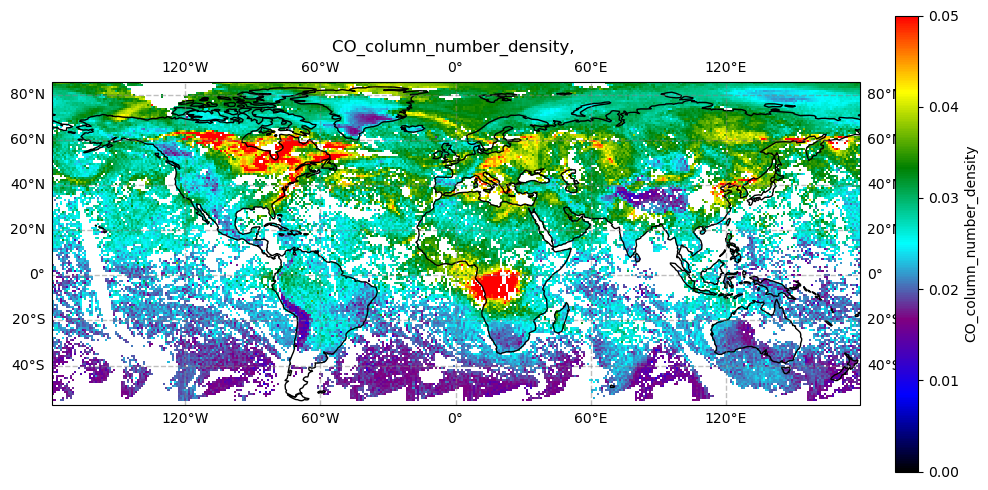

In [2]:
""" animation with lon/lat """
import matplotlib.pyplot as plt
from matplotlib import animation
import cartopy.crs as ccrs
from IPython.display import HTML
from matplotlib.colors import LinearSegmentedColormap

ds = ds_s5p
band_name = 'CO_column_number_density'
vmin = 0
vmax = 0.05
palette = ['black', 'blue', 'purple', 'cyan', 'green', 'yellow', 'red']
cmap = LinearSegmentedColormap.from_list("my_colormap", palette)


da = ds[band_name]

fig = plt.figure(figsize=(10, 5)) # Define the figure and specify size
ax = plt.subplot(1,1,1, projection=ccrs.PlateCarree()) # Specify plot area & projection
ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--') # Add lat/lon grid
ax.set_title(f'{band_name}, {str(da.time[0].values)[:-16]}', fontsize=12) # Set figure title
ax.coastlines(color='black') # Add coastlines
if 'lon' in ds.dims.keys():
    im = plt.pcolormesh(da.lon, da.lat, da[0,:,:].transpose(), cmap=cmap, vmin=vmin, vmax=vmax) # Plot the data
if 'X' in ds.dims.keys():
    im = plt.pcolormesh(da.X, da.Y, da[0,:,:].transpose(), cmap=cmap, vmin=vmin, vmax=vmax) # Plot the data
cbar = plt.colorbar(im, fraction=0.046, pad=0) # Specify the colourbar
cbar.set_label(f'{band_name}') # Define the colourbar label

frames = da.shape[0]
def animate(i):
    array = da[i,:,:].transpose().values
    im.set_array(array.flatten())
    # plt.imshow(da[i,:,:])
    ax.set_title(f'{band_name}, {str(da.time[i].values)[:-frames]}', fontsize=12)

fig.tight_layout()

ani = animation.FuncAnimation(fig, animate, frames, interval=150)
ani.save(f'outputs/{band_name}_animation.gif') # save to animated gif
HTML(ani.to_jshtml())

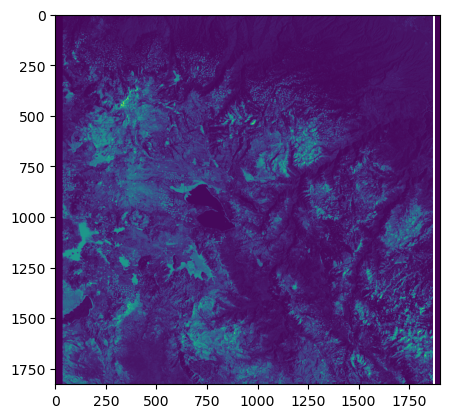

In [14]:
HTML(ani.to_html5_video())